# Part 2: Generalization across subjects

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from pathlib import Path

In [3]:
DATA_DIR = Path("data")
N_SUBJECTS = 27

### 1. Consider now 27 subjects (only exercise set 1 as in part 1). Perform the same preprocessing pipeline as in part 1.

In [4]:
all_emg = {}
all_stimulus = {}
all_repetition = {}

for subj in range(1, N_SUBJECTS + 1):
    # Correct path: data/sX/sX_A1_E1.mat
    file_path = DATA_DIR / f"s{subj}" / f"s{subj}_A1_E1.mat"
    
    print(f"Loading subject {subj}: {file_path}")

    data = loadmat(file_path)

    emg = data["emg"]
    stimulus = data["restimulus"].squeeze()
    repetition = data["rerepetition"].squeeze()

    all_emg[subj] = emg
    all_stimulus[subj] = stimulus
    all_repetition[subj] = repetition

Loading subject 1: data/s1/s1_A1_E1.mat
Loading subject 2: data/s2/s2_A1_E1.mat
Loading subject 3: data/s3/s3_A1_E1.mat
Loading subject 4: data/s4/s4_A1_E1.mat
Loading subject 5: data/s5/s5_A1_E1.mat
Loading subject 6: data/s6/s6_A1_E1.mat
Loading subject 7: data/s7/s7_A1_E1.mat
Loading subject 8: data/s8/s8_A1_E1.mat
Loading subject 9: data/s9/s9_A1_E1.mat
Loading subject 10: data/s10/s10_A1_E1.mat
Loading subject 11: data/s11/s11_A1_E1.mat
Loading subject 12: data/s12/s12_A1_E1.mat
Loading subject 13: data/s13/s13_A1_E1.mat
Loading subject 14: data/s14/s14_A1_E1.mat
Loading subject 15: data/s15/s15_A1_E1.mat
Loading subject 16: data/s16/s16_A1_E1.mat
Loading subject 17: data/s17/s17_A1_E1.mat
Loading subject 18: data/s18/s18_A1_E1.mat
Loading subject 19: data/s19/s19_A1_E1.mat
Loading subject 20: data/s20/s20_A1_E1.mat
Loading subject 21: data/s21/s21_A1_E1.mat
Loading subject 22: data/s22/s22_A1_E1.mat
Loading subject 23: data/s23/s23_A1_E1.mat
Loading subject 24: data/s24/s24_A1_E1

### 2. Extract the same set of features. Now look at the values of those features across the different subjects. Are there any similarity/discrepancies between the subjects?

In [5]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [6]:
mav  = lambda x: np.mean(np.abs(x), axis=0)
std  = lambda x: np.std(x, axis=0)
maxav = lambda x: np.max(np.abs(x), axis=0)
rms  = lambda x: np.sqrt(np.mean(x**2, axis=0))
wl   = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

def ssc(x, eps=1e-6):
    diff1 = x[1:-1, :] - x[:-2, :]
    diff2 = x[1:-1, :] - x[2:, :]
    return np.sum((diff1 * diff2 < -eps).astype(int), axis=0)

features = [mav, std, maxav, rms, wl, ssc]

In [7]:
all_datasets = {}   # subj → feature matrix (n_trials, n_features)
all_labels = {}     # subj → labels (n_trials,)

for subj in range(1, N_SUBJECTS + 1):
    print(f"\nBuilding dataset for subject {subj}")

    emg = all_emg[subj]
    stimulus = all_stimulus[subj]
    repetition = all_repetition[subj]

    X_subj, y_subj = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=features,
    )

    print(f"  X_subj shape: {X_subj.shape}, y_subj shape: {y_subj.shape}")

    all_datasets[subj] = X_subj
    all_labels[subj] = y_subj



Building dataset for subject 1
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 2
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 3
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 4
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 5
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 6
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 7
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 8
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 9
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 10
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 11
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 12
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 13
  X_

In [8]:
feature_types = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"]
n_channels = 10
n_feat_per_channel = len(feature_types)

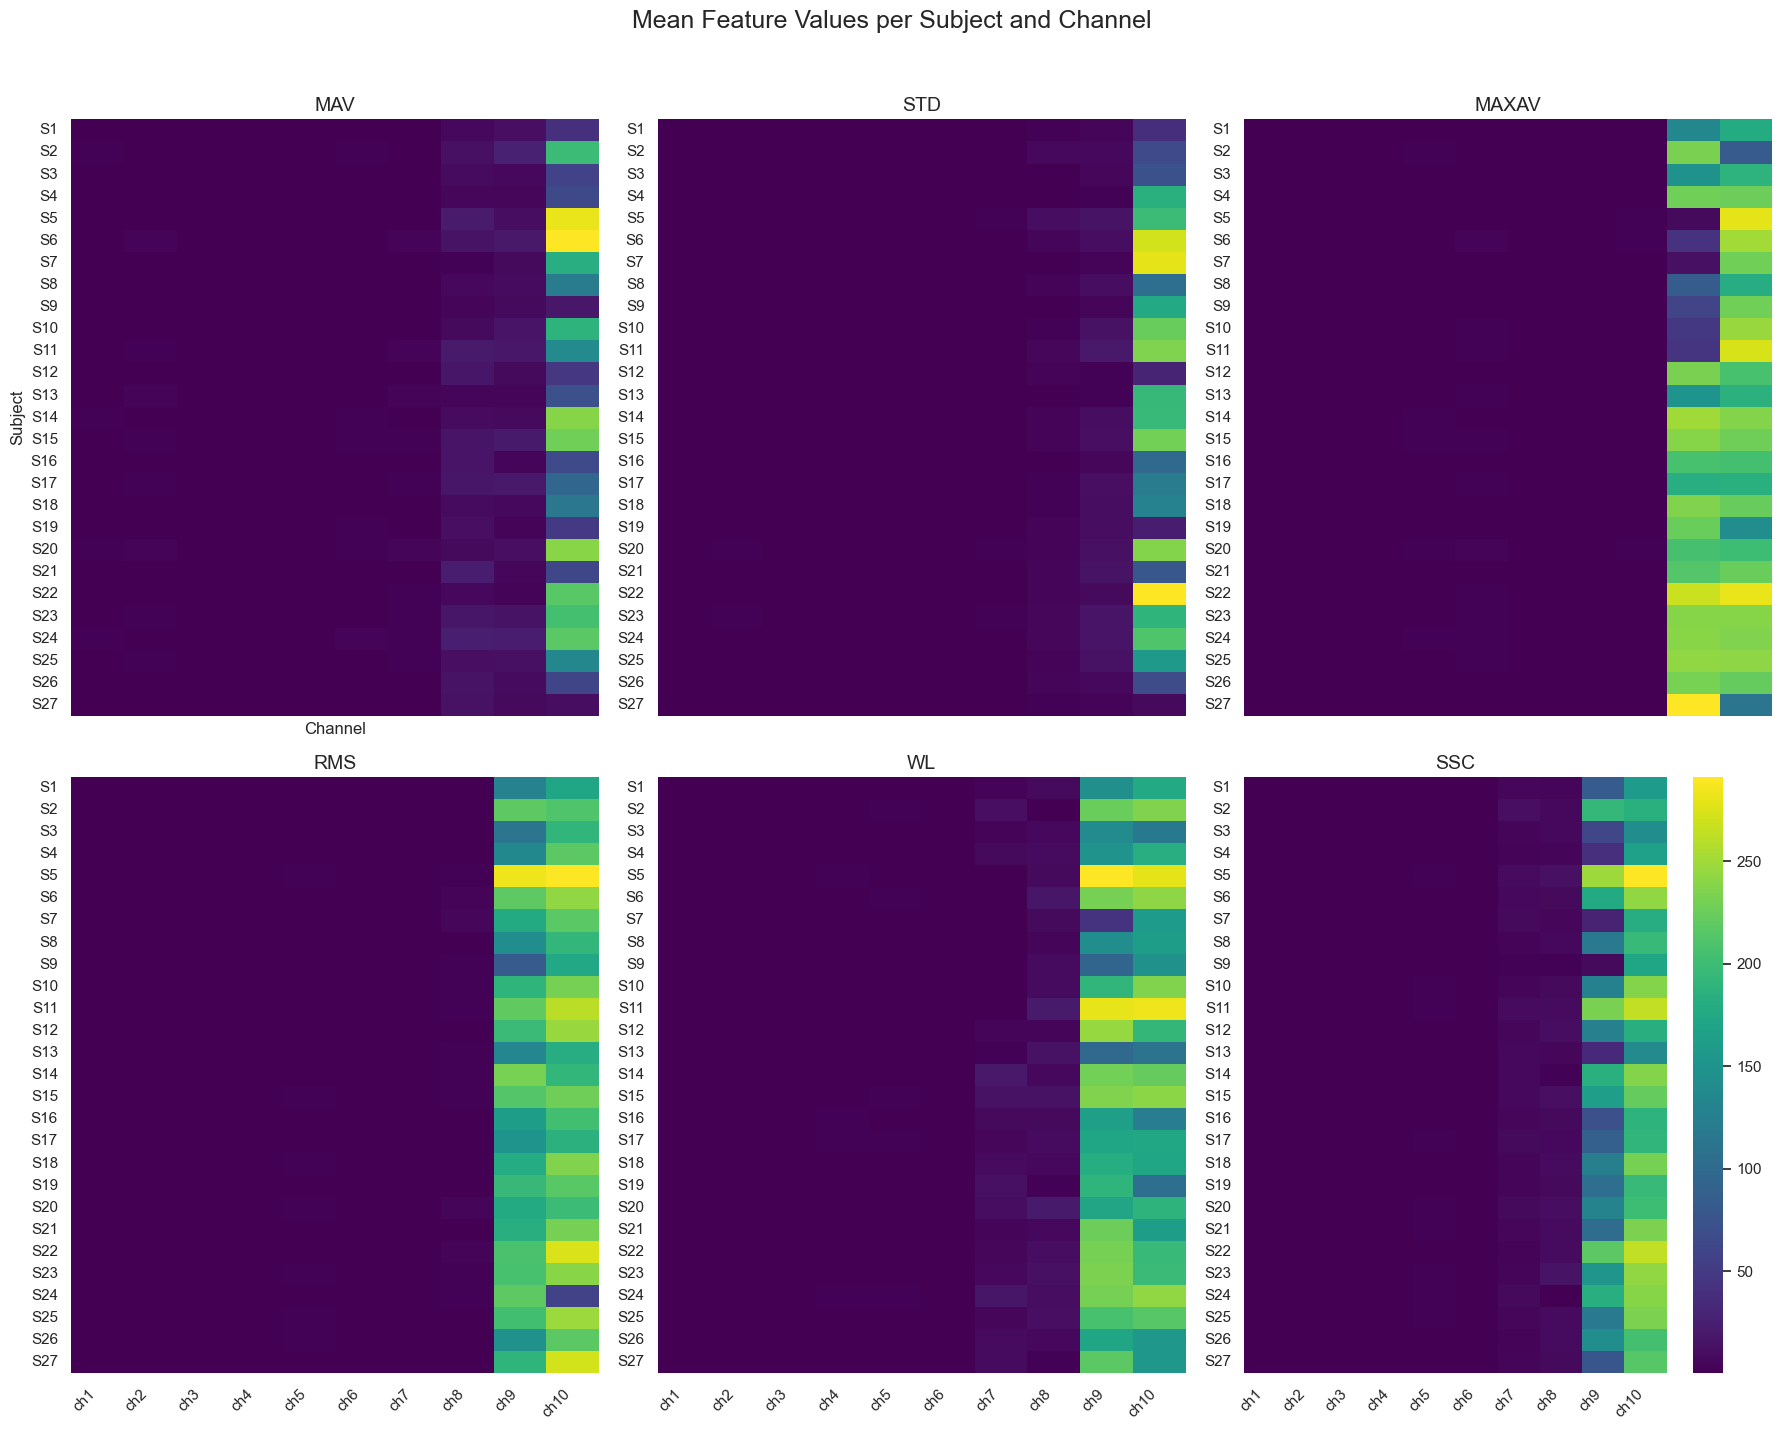

In [9]:
sns.set()

n_feat_types = len(feature_types)

# means[f_idx, subj-1, ch] = mean value of that feature for that subject & channel
means = np.zeros((n_feat_types, N_SUBJECTS, n_channels))

for f_idx, ftype in enumerate(feature_types):
    for subj in range(1, N_SUBJECTS + 1):
        Xs = all_datasets[subj]  # (n_trials_subj, n_features)

        for ch in range(n_channels):
            # index of this (channel, feature_type) in the flattened features
            global_idx = ch * n_feat_per_channel + f_idx
            vals = Xs[:, global_idx]
            means[f_idx, subj-1, ch] = vals.mean()


fig, axes = plt.subplots(2, 3, figsize=(18, 14), sharex=True)  
axes = axes.ravel()

for f_idx, ftype in enumerate(feature_types):
    ax = axes[f_idx]

    sns.heatmap(
        means[f_idx],
        ax=ax,
        cmap="viridis",
        cbar=f_idx == len(feature_types) - 1,  # only last subplot has a colorbar
        xticklabels=[f"ch{c+1}" for c in range(n_channels)],
        yticklabels=[f"S{subj}" for subj in range(1, N_SUBJECTS + 1)]
    )

    ax.set_title(ftype, fontsize=14)

    # Remove axis labels from all but ONE subplot
    if f_idx != 0:
        ax.set_ylabel("")
        ax.set_xlabel("")
    else:
        ax.set_ylabel("Subject", fontsize=12)
        ax.set_xlabel("Channel", fontsize=12)

    # Rotate x tick labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.suptitle("Mean Feature Values per Subject and Channel", fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig("feature_heatmaps_subjects.png", dpi=150, bbox_inches='tight')
plt.show()

**STATISTICAL ANALYSIS: Similarities and Discrepancies Between Subjects**

In [10]:
from scipy.stats import spearmanr, kruskal

# 1. Compute subject-level feature vectors (mean across all trials)
subject_feature_means = np.array([all_datasets[s].mean(axis=0) for s in range(1, N_SUBJECTS + 1)])

# 2. Inter-subject correlation matrix (Spearman correlation)
subject_corr_matrix = np.zeros((N_SUBJECTS, N_SUBJECTS))
for i in range(N_SUBJECTS):
    for j in range(N_SUBJECTS):
        corr, _ = spearmanr(subject_feature_means[i], subject_feature_means[j])
        subject_corr_matrix[i, j] = corr

# 3. Coefficient of Variation (CV) per feature across subjects
feature_cv = np.std(subject_feature_means, axis=0) / (np.mean(subject_feature_means, axis=0) + 1e-10)

# 4. Kruskal-Wallis test per feature (non-parametric test)
kruskal_pvalues = []
for feat_idx in range(subject_feature_means.shape[1]):
    groups = [all_datasets[s][:, feat_idx] for s in range(1, N_SUBJECTS + 1)]
    stat, pval = kruskal(*groups)
    kruskal_pvalues.append(pval)
kruskal_pvalues = np.array(kruskal_pvalues)

**Inter-subject correlation heatmap**

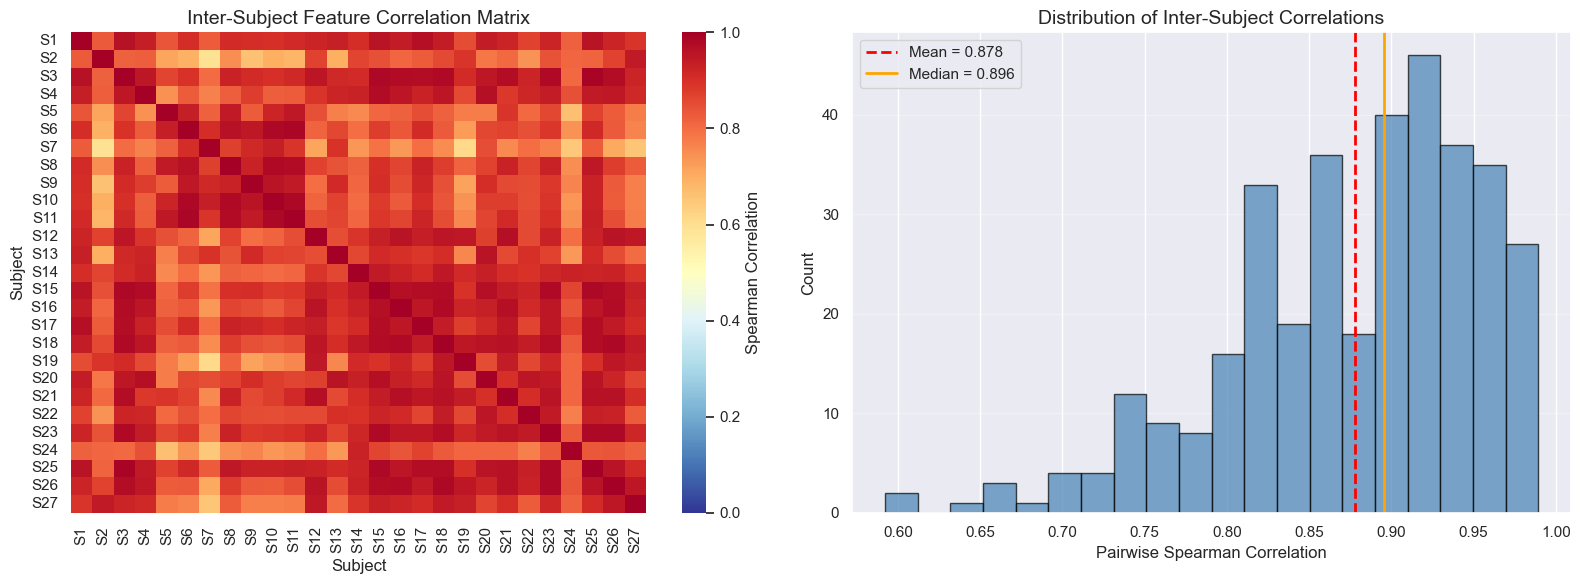

-  Mean correlation:   0.878
-  Std correlation:    0.076
-  Min correlation:    0.592
-  Max correlation:    0.989


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
mask = np.triu(np.ones_like(subject_corr_matrix, dtype=bool), k=1)
sns.heatmap(
    subject_corr_matrix,
    ax=ax1,
    cmap='RdYlBu_r',
    vmin=0, vmax=1,
    annot=False,
    xticklabels=[f"S{i}" for i in range(1, N_SUBJECTS + 1)],
    yticklabels=[f"S{i}" for i in range(1, N_SUBJECTS + 1)],
    cbar_kws={'label': 'Spearman Correlation'}
)
ax1.set_title('Inter-Subject Feature Correlation Matrix', fontsize=14)
ax1.set_xlabel('Subject')
ax1.set_ylabel('Subject')

# Distribution of pairwise correlations (excluding diagonal)
ax2 = axes[1]
off_diag_corrs = subject_corr_matrix[np.triu_indices(N_SUBJECTS, k=1)]
ax2.hist(off_diag_corrs, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(off_diag_corrs.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {off_diag_corrs.mean():.3f}')
ax2.axvline(np.median(off_diag_corrs), color='orange', linestyle='-', linewidth=2,
            label=f'Median = {np.median(off_diag_corrs):.3f}')
ax2.set_xlabel('Pairwise Spearman Correlation', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Inter-Subject Correlations', fontsize=14)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("inter_subject_correlation.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"-  Mean correlation:   {off_diag_corrs.mean():.3f}")
print(f"-  Std correlation:    {off_diag_corrs.std():.3f}")
print(f"-  Min correlation:    {off_diag_corrs.min():.3f}")
print(f"-  Max correlation:    {off_diag_corrs.max():.3f}")

**Coefficient of Variation per feature type**

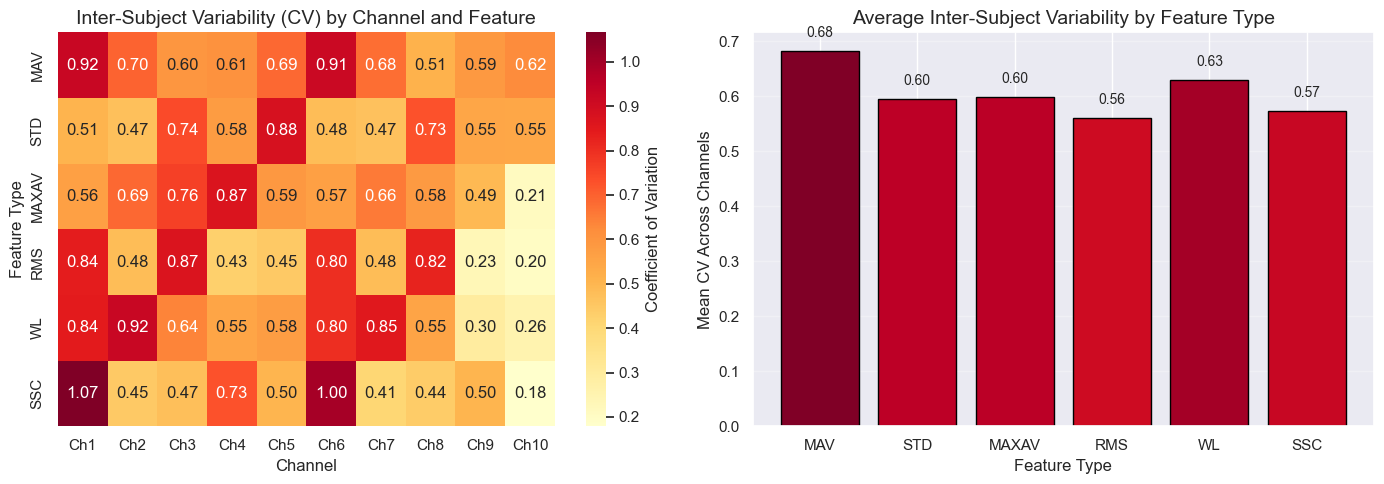

Most variable feature:  MAV (CV = 0.682)
Least variable feature: RMS (CV = 0.561)


In [ ]:
cv_reshaped = feature_cv.reshape(n_channels, n_feat_per_channel)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CV heatmap by channel and feature type
ax1 = axes[0]
sns.heatmap(
    cv_reshaped.T,
    ax=ax1,
    cmap='YlOrRd',
    annot=True,
    fmt='.2f',
    xticklabels=[f"Ch{i+1}" for i in range(n_channels)],
    yticklabels=feature_types,
    cbar_kws={'label': 'Coefficient of Variation'}
)
ax1.set_title('Inter-Subject Variability (CV) by Channel and Feature', fontsize=14)
ax1.set_xlabel('Channel')
ax1.set_ylabel('Feature Type')

# Bar plot of mean CV per feature type
ax2 = axes[1]
mean_cv_per_feat = cv_reshaped.mean(axis=0)
colors = plt.cm.YlOrRd(mean_cv_per_feat / mean_cv_per_feat.max())
bars = ax2.bar(feature_types, mean_cv_per_feat, color=colors, edgecolor='black')
ax2.set_xlabel('Feature Type', fontsize=12)
ax2.set_ylabel('Mean CV Across Channels', fontsize=12)
ax2.set_title('Average Inter-Subject Variability by Feature Type', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, mean_cv_per_feat):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("coefficient_of_variation.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Most variable feature:  {feature_types[mean_cv_per_feat.argmax()]} (CV = {mean_cv_per_feat.max():.3f})")
print(f"Least variable feature: {feature_types[mean_cv_per_feat.argmin()]} (CV = {mean_cv_per_feat.min():.3f})")

**Statistical significance of inter-subject differences (Kruskal-Wallis)**

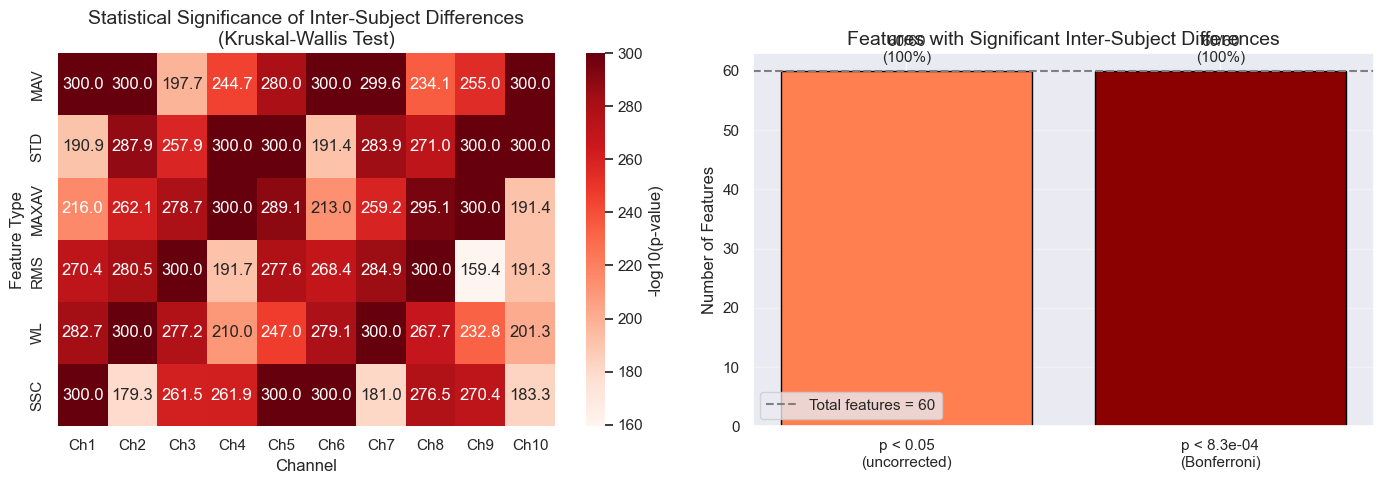

Total features: 60
Significant at α=0.05: 60 (100.0%)
Significant after Bonferroni: 60 (100.0%)


In [14]:
pvals_reshaped = kruskal_pvalues.reshape(n_channels, n_feat_per_channel)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
log_pvals = -np.log10(pvals_reshaped.T + 1e-300)  # add small value to avoid log(0)
sns.heatmap(
    log_pvals,
    ax=ax1,
    cmap='Reds',
    annot=True,
    fmt='.1f',
    xticklabels=[f"Ch{i+1}" for i in range(n_channels)],
    yticklabels=feature_types,
    cbar_kws={'label': '-log10(p-value)'}
)
ax1.set_title('Statistical Significance of Inter-Subject Differences\n(Kruskal-Wallis Test)', fontsize=14)
ax1.set_xlabel('Channel')
ax1.set_ylabel('Feature Type')

# Summary: proportion of features with significant differences
ax2 = axes[1]
alpha = 0.05
bonferroni_alpha = alpha / len(kruskal_pvalues)  # Bonferroni correction

sig_uncorrected = (kruskal_pvalues < alpha).sum()
sig_corrected = (kruskal_pvalues < bonferroni_alpha).sum()

bars = ax2.bar(['p < 0.05\n(uncorrected)', f'p < {bonferroni_alpha:.1e}\n(Bonferroni)'],
               [sig_uncorrected, sig_corrected],
               color=['coral', 'darkred'], edgecolor='black')
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Features with Significant Inter-Subject Differences', fontsize=14)
ax2.axhline(len(kruskal_pvalues), color='gray', linestyle='--', label=f'Total features = {len(kruskal_pvalues)}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, [sig_uncorrected, sig_corrected]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val}/{len(kruskal_pvalues)}\n({100*val/len(kruskal_pvalues):.0f}%)', 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("kruskal_wallis_significance.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Total features: {len(kruskal_pvalues)}")
print(f"Significant at α=0.05: {sig_uncorrected} ({100*sig_uncorrected/len(kruskal_pvalues):.1f}%)")
print(f"Significant after Bonferroni: {sig_corrected} ({100*sig_corrected/len(kruskal_pvalues):.1f}%)")

**Feature distributions across subjects**

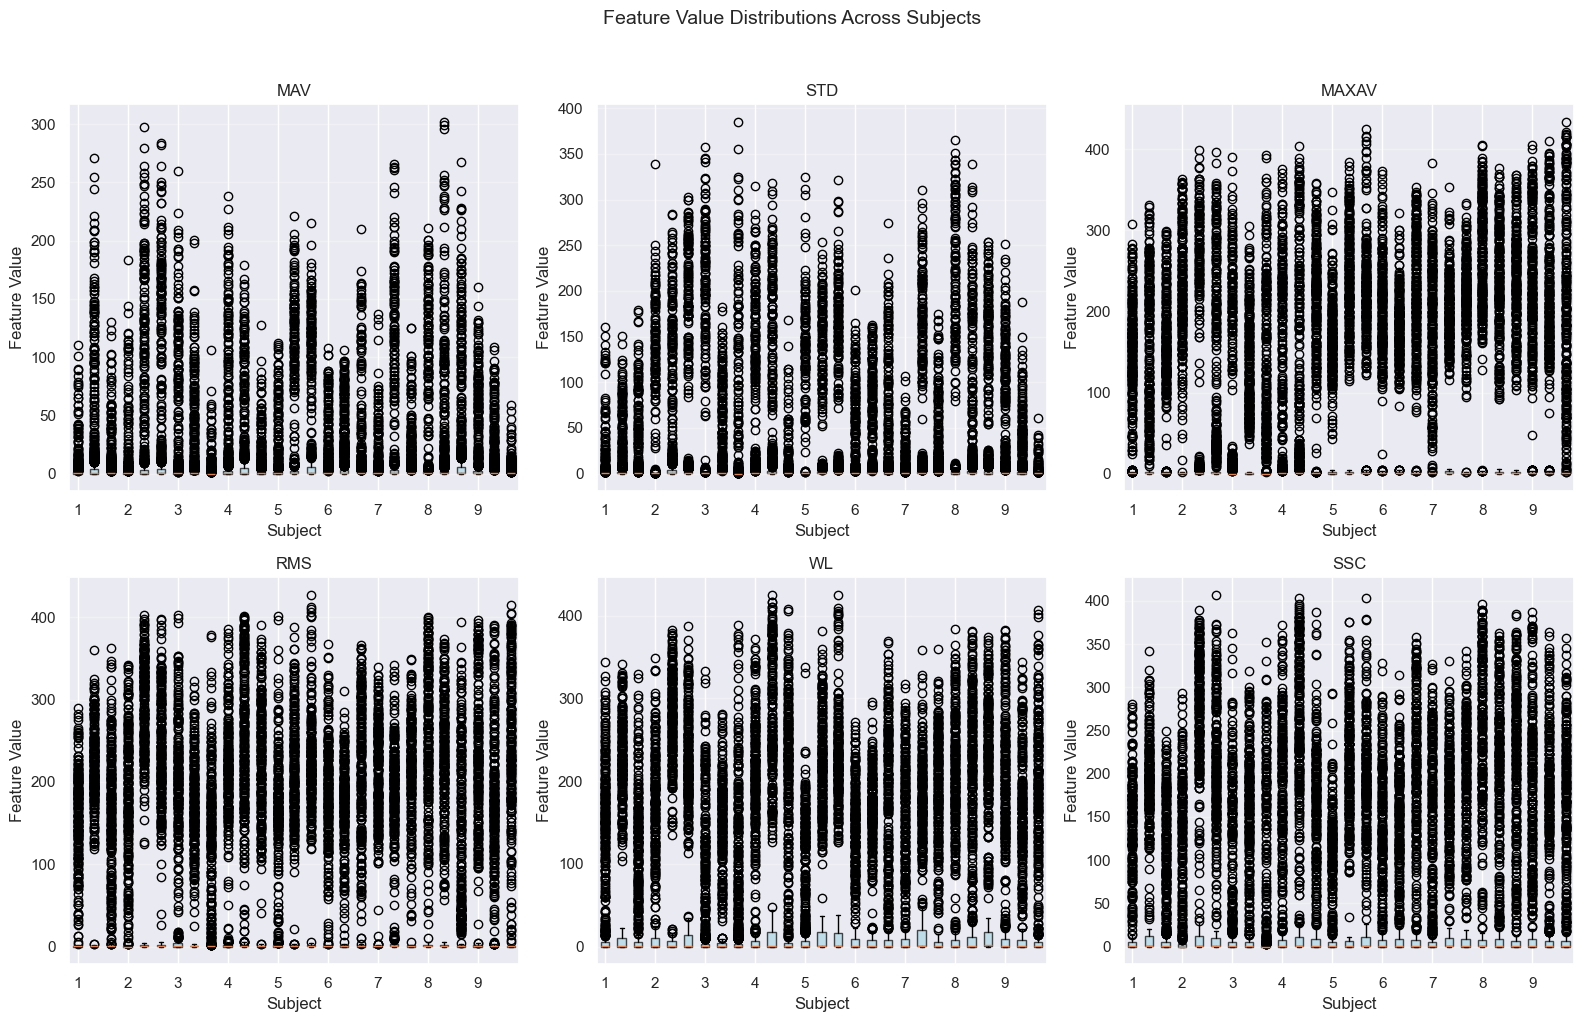

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for f_idx, ftype in enumerate(feature_types):
    ax = axes[f_idx]
    
    data_per_subj = []
    for subj in range(1, N_SUBJECTS + 1):
        Xs = all_datasets[subj]
        feat_vals = []
        for ch in range(n_channels):
            global_idx = ch * n_feat_per_channel + f_idx
            feat_vals.extend(Xs[:, global_idx])
        data_per_subj.append(feat_vals)
    
    bp = ax.boxplot(data_per_subj, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax.set_title(f'{ftype}', fontsize=12)
    ax.set_xlabel('Subject')
    ax.set_ylabel('Feature Value')
    ax.set_xticks(range(1, N_SUBJECTS + 1, 3))
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Feature Value Distributions Across Subjects', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("feature_boxplots_subjects.png", dpi=150, bbox_inches='tight')
plt.show()

### 3. Train a classification model (same model as part 1) on 26 subjects (aggregating the data) and test it on a subject outside the train set. Evaluate the performance. How does it compare to training and testing on the same subject directly?

In [18]:
test_subj = 5

# Test data = subject 5
X_test = all_datasets[test_subj]
y_test = all_labels[test_subj]

# Train data = all subjects except 5
X_train = np.vstack([
    all_datasets[subj]
    for subj in range(1, N_SUBJECTS + 1)
    if subj != test_subj
])
y_train = np.concatenate([
    all_labels[subj]
    for subj in range(1, N_SUBJECTS + 1)
    if subj != test_subj
])

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# Scale using only training subjects
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z  = scaler.transform(X_test)

# Use best GB hyperparameters from Part 1 
clf_cross = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.6,
    random_state=0,
)

clf_cross.fit(X_train_z, y_train)
y_pred_cross = clf_cross.predict(X_test_z)

acc_cross = accuracy_score(y_test, y_pred_cross)
print(f"\nAccuracy when training on 26 subjects and testing on Subject {test_subj}: {acc_cross:.3f}")


Train shape: (3120, 60)
Test shape : (120, 60)

Accuracy when training on 26 subjects and testing on Subject 5: 0.408


### 4. Perform cross-validation by rotating the subject used for testing. Specifically, for each fold, select one subject as the test set and use the remaining 26 subjects to train the model. Repeat this process for all 27 subjects, ensuring each subject is used as the test set exactly once. Evaluate and compare the performance across all folds to understand how well the model generalizes to new subjects. 

In [19]:
# Leave-One-Subject-Out Cross-Validation (LOSO-CV)
loso_accuracies = []

for test_subj in range(1, N_SUBJECTS + 1):
    # Test data = current subject
    X_test = all_datasets[test_subj]
    y_test = all_labels[test_subj]
    
    # Train data = all other subjects
    X_train = np.vstack([
        all_datasets[subj]
        for subj in range(1, N_SUBJECTS + 1)
        if subj != test_subj
    ])
    y_train = np.concatenate([
        all_labels[subj]
        for subj in range(1, N_SUBJECTS + 1)
        if subj != test_subj
    ])
    
    # Standardize
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    
    # Train classifier
    clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=2,
        subsample=0.6,
        random_state=0,
    )
    clf.fit(X_train_z, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test_z)
    acc = accuracy_score(y_test, y_pred)
    loso_accuracies.append(acc)
    
    print(f"Subject {test_subj:2d} as test set: Accuracy = {acc:.3f}")

loso_accuracies = np.array(loso_accuracies)
print(f"\n{'='*50}")
print(f"LOSO-CV Mean Accuracy: {loso_accuracies.mean():.3f} ± {loso_accuracies.std():.3f}")
print(f"Min: {loso_accuracies.min():.3f} (Subject {loso_accuracies.argmin()+1})")
print(f"Max: {loso_accuracies.max():.3f} (Subject {loso_accuracies.argmax()+1})")

Subject  1 as test set: Accuracy = 0.358
Subject  2 as test set: Accuracy = 0.133
Subject  3 as test set: Accuracy = 0.433
Subject  4 as test set: Accuracy = 0.258
Subject  5 as test set: Accuracy = 0.408
Subject  6 as test set: Accuracy = 0.300
Subject  7 as test set: Accuracy = 0.350
Subject  8 as test set: Accuracy = 0.433
Subject  9 as test set: Accuracy = 0.258
Subject 10 as test set: Accuracy = 0.350
Subject 11 as test set: Accuracy = 0.267
Subject 12 as test set: Accuracy = 0.325
Subject 13 as test set: Accuracy = 0.275
Subject 14 as test set: Accuracy = 0.333
Subject 15 as test set: Accuracy = 0.408
Subject 16 as test set: Accuracy = 0.392
Subject 17 as test set: Accuracy = 0.483
Subject 18 as test set: Accuracy = 0.375
Subject 19 as test set: Accuracy = 0.217
Subject 20 as test set: Accuracy = 0.258
Subject 21 as test set: Accuracy = 0.392
Subject 22 as test set: Accuracy = 0.275
Subject 23 as test set: Accuracy = 0.450
Subject 24 as test set: Accuracy = 0.192
Subject 25 as te

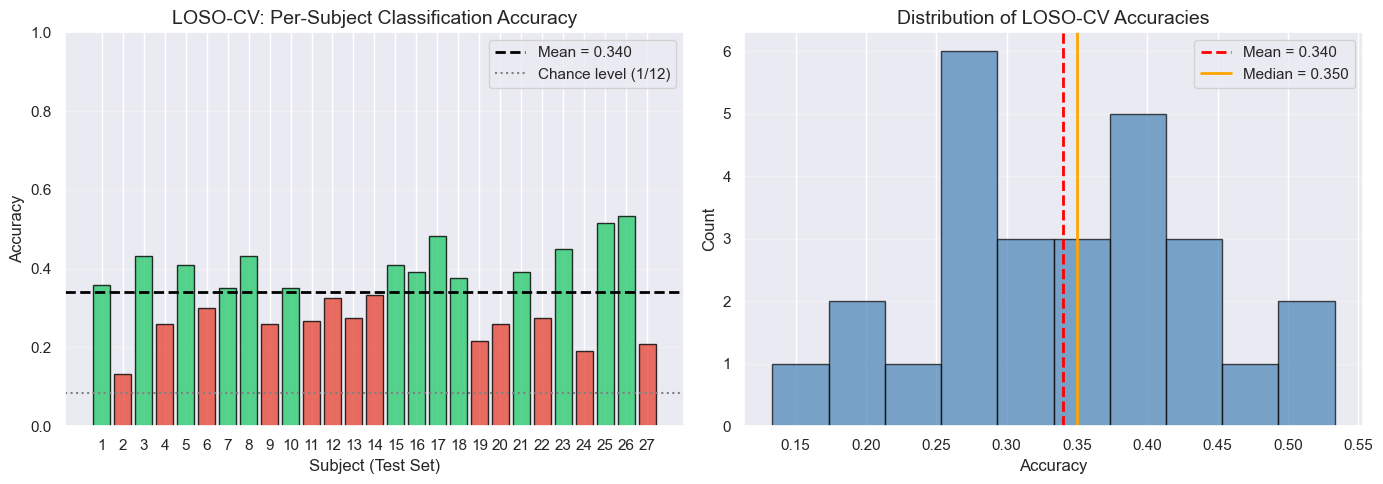

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of per-subject accuracy
ax1 = axes[0]
colors = ['#2ecc71' if acc >= loso_accuracies.mean() else '#e74c3c' for acc in loso_accuracies]
bars = ax1.bar(range(1, N_SUBJECTS + 1), loso_accuracies, color=colors, edgecolor='black', alpha=0.8)
ax1.axhline(loso_accuracies.mean(), color='black', linestyle='--', linewidth=2, label=f'Mean = {loso_accuracies.mean():.3f}')
ax1.axhline(1/12, color='gray', linestyle=':', linewidth=1.5, label='Chance level (1/12)')
ax1.set_xlabel('Subject (Test Set)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('LOSO-CV: Per-Subject Classification Accuracy', fontsize=14)
ax1.set_xticks(range(1, N_SUBJECTS + 1))
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Distribution of accuracies
ax2 = axes[1]
ax2.hist(loso_accuracies, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(loso_accuracies.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {loso_accuracies.mean():.3f}')
ax2.axvline(np.median(loso_accuracies), color='orange', linestyle='-', linewidth=2, label=f'Median = {np.median(loso_accuracies):.3f}')
ax2.set_xlabel('Accuracy', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of LOSO-CV Accuracies', fontsize=14)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("loso_cv_results.png", dpi=150, bbox_inches='tight')
plt.show()

### 5. Repeat task 3 by varying the number of subjects in the training set (without performing cross-validation). For example, use subject 27 for testing, and train with subject 1, then train with subjects 1 and 2, then 1, 2, and 3, and continue to increase number of subjects used for training. Analyze how the size of the training set impacts the classification performance on the test subject. Discuss the practical implications of including more or fewer subjects in the training data, focusing on trends in generalization and accuracy. If you had to train a decoder, what would be your ideal training dataset and why?

In [21]:
test_subj = 27
X_test = all_datasets[test_subj]
y_test = all_labels[test_subj]

train_sizes = list(range(1, N_SUBJECTS))  # 1 to 26 subjects
accuracies_by_size = []

for n_train in train_sizes:
    # Use subjects 1, 2, ..., n_train for training
    train_subjects = list(range(1, n_train + 1))
    
    X_train = np.vstack([all_datasets[subj] for subj in train_subjects])
    y_train = np.concatenate([all_labels[subj] for subj in train_subjects])
    
    # Standardize
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    
    # Train classifier
    clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=2,
        subsample=0.6,
        random_state=0,
    )
    clf.fit(X_train_z, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test_z)
    acc = accuracy_score(y_test, y_pred)
    accuracies_by_size.append(acc)
    
    print(f"Training with {n_train:2d} subject(s): Accuracy = {acc:.3f}")

accuracies_by_size = np.array(accuracies_by_size)

Training with  1 subject(s): Accuracy = 0.025
Training with  2 subject(s): Accuracy = 0.192
Training with  3 subject(s): Accuracy = 0.208
Training with  4 subject(s): Accuracy = 0.158
Training with  5 subject(s): Accuracy = 0.117
Training with  6 subject(s): Accuracy = 0.125
Training with  7 subject(s): Accuracy = 0.117
Training with  8 subject(s): Accuracy = 0.142
Training with  9 subject(s): Accuracy = 0.133
Training with 10 subject(s): Accuracy = 0.133
Training with 11 subject(s): Accuracy = 0.150
Training with 12 subject(s): Accuracy = 0.217
Training with 13 subject(s): Accuracy = 0.175
Training with 14 subject(s): Accuracy = 0.200
Training with 15 subject(s): Accuracy = 0.158
Training with 16 subject(s): Accuracy = 0.183
Training with 17 subject(s): Accuracy = 0.200
Training with 18 subject(s): Accuracy = 0.217
Training with 19 subject(s): Accuracy = 0.217
Training with 20 subject(s): Accuracy = 0.208
Training with 21 subject(s): Accuracy = 0.217
Training with 22 subject(s): Accur

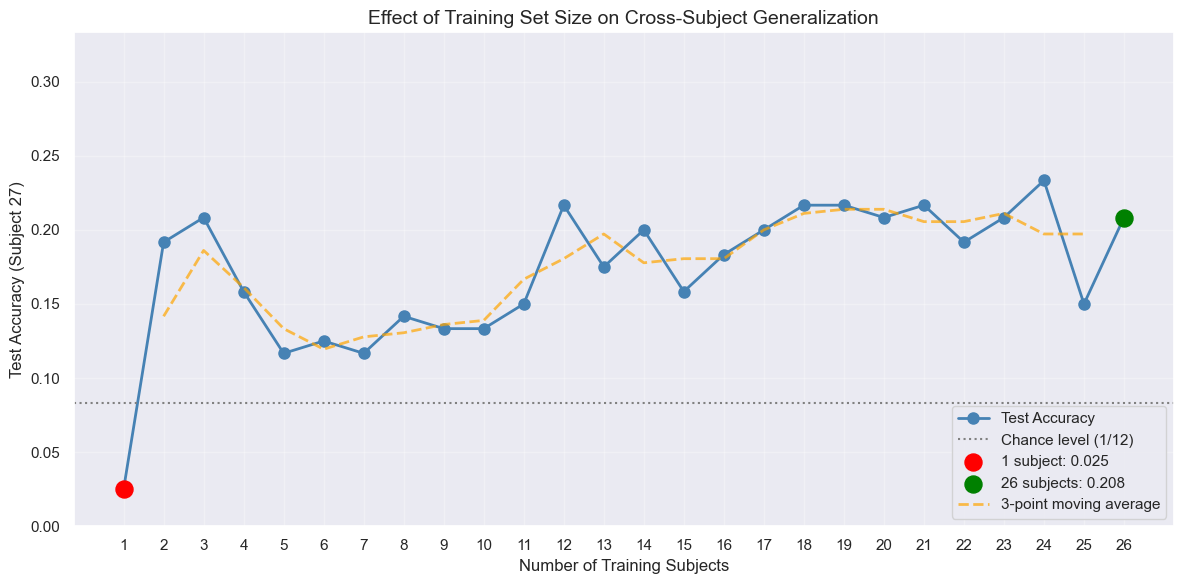


Accuracy with 1 training subject:  0.025
Accuracy with 26 training subjects: 0.208
Improvement: 0.183 (733.3% relative increase)

Best accuracy: 0.233 with 24 subject(s)
Worst accuracy: 0.025 with 1 subject(s)


In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_sizes, accuracies_by_size, 'o-', linewidth=2, markersize=8, color='steelblue', label='Test Accuracy')
ax.axhline(1/12, color='gray', linestyle=':', linewidth=1.5, label='Chance level (1/12)')

# Highlight key points
ax.scatter([1], [accuracies_by_size[0]], color='red', s=150, zorder=5, label=f'1 subject: {accuracies_by_size[0]:.3f}')
ax.scatter([26], [accuracies_by_size[-1]], color='green', s=150, zorder=5, label=f'26 subjects: {accuracies_by_size[-1]:.3f}')

# Add trend line (moving average)
window = 3
if len(accuracies_by_size) > window:
    smoothed = np.convolve(accuracies_by_size, np.ones(window)/window, mode='valid')
    ax.plot(train_sizes[window//2:-window//2+1], smoothed, '--', color='orange', linewidth=2, alpha=0.7, label=f'{window}-point moving average')

ax.set_xlabel('Number of Training Subjects', fontsize=12)
ax.set_ylabel('Test Accuracy (Subject 27)', fontsize=12)
ax.set_title('Effect of Training Set Size on Cross-Subject Generalization', fontsize=14)
ax.set_xticks(train_sizes)
ax.set_ylim(0, max(accuracies_by_size) + 0.1)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_size_effect.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAccuracy with 1 training subject:  {accuracies_by_size[0]:.3f}")
print(f"Accuracy with 26 training subjects: {accuracies_by_size[-1]:.3f}")
print(f"Improvement: {(accuracies_by_size[-1] - accuracies_by_size[0]):.3f} ({(accuracies_by_size[-1]/accuracies_by_size[0] - 1)*100:.1f}% relative increase)")
print(f"\nBest accuracy: {accuracies_by_size.max():.3f} with {train_sizes[accuracies_by_size.argmax()]} subject(s)")
print(f"Worst accuracy: {accuracies_by_size.min():.3f} with {train_sizes[accuracies_by_size.argmin()]} subject(s)")